In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.TopoExplanation import *
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm

In [2]:
n_samples = 100

## Generate a Synthetic Dataset with 4 correlated features and 2 redundant features

In [3]:
import seaborn as sns
from sympy import symbols

from synthetic_data import make_tabular_data, tuples_to_cov
# define symbols
all_symbs = symbols("x1 x2 x3 x4 x5 x6")
x1, x2, x3, x4, x5, x6 = all_symbs
# define expression
# expr = sum(x**i for i,x in enumerate(all_symbs, 1))
# expr = sum(x for i,x in enumerate(all_symbs, 1))
expr = (
    1*x1
    + 1*x2
    + 1*x3
    + 1*x4
    + 0*x5
    + 0*x6
)

# define mapping from symbols to column of X
col_map = {k: idx for idx, k in enumerate(all_symbs)}
# define correlations via covariance matrix
#cov = np.identity(len(all_symbs))
cov = tuples_to_cov([], col_map)

dist = [{"column": idx, "dist": "norm"} for idx in range(len(all_symbs))]

X, y_reg, y_prob, y_label = make_tabular_data(
    dist=dist,
    n_informative=len(col_map.keys()),
    n_samples=n_samples,
    cov=cov,
    col_map=col_map,
    expr=expr,
    p_thresh=0.5,
    sig_x0=0.0,
    seed=111,
)


## Overview of the Synthetic Data

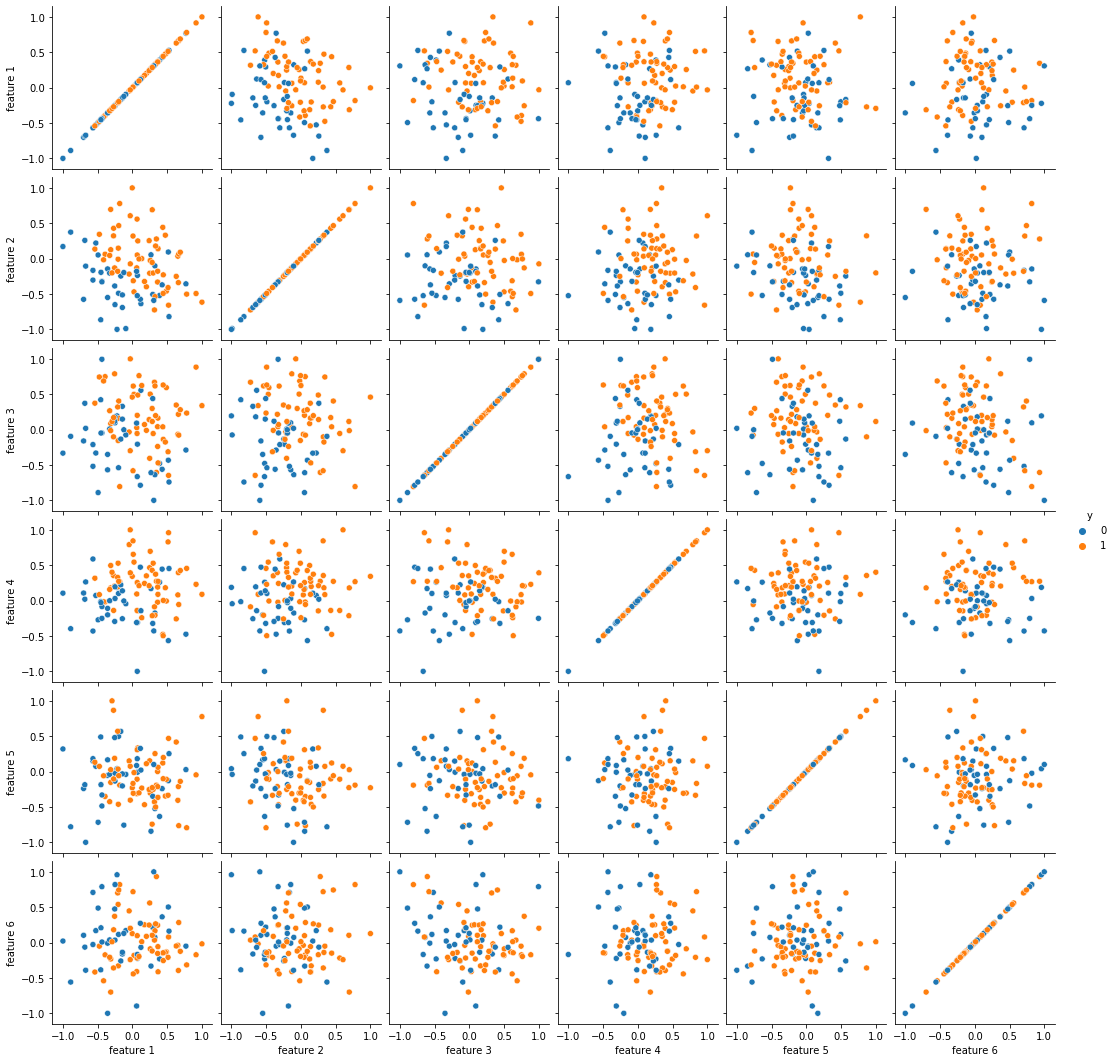

In [5]:
df = pd.DataFrame(np.hstack((X,np.array(y_label).reshape(-1,1))))
df.columns = ['feature {}'.format(i) for i in range(1,7)] + ['y']
df.y = df.y.astype(int).astype(str)
sns.pairplot(df,hue='y',hue_order=['0','1'],diag_kind = None)

## Train a Random Forest Classifier on the data

In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y_label)
preds = model.predict_proba(X)[:, 0]  # just class 0 (binary classificaiton)

## Running LIME explanations on the data

In [105]:
def run_lime(X, model, num_features, num_samples=100):
    explainer = LimeTabularExplainer(X, discretize_continuous=False)
    lime_exp = []
    for x in tqdm(X):
        exp = explainer.explain_instance(x, model.predict_proba, num_features=num_features, num_samples=num_samples)
        tmp = [0 for i in range(X.shape[1])]
        for e in exp.as_list():
            tmp[int(e[0])] = e[1]
        lime_exp.append(tmp)
    lime_exp = np.array(lime_exp)
    return lime_exp

In [106]:
all_lime = {}
all_mappers = {}
for num_features in range(2, 1 + len(all_symbs)):
    lime_exp = run_lime(X, model, num_features=num_features)
    all_lime[num_features] = lime_exp

100%|██████████| 100/100 [00:04<00:00, 20.81it/s]


## Prediction prbability as filter function for topological graph construction

In [ ]:
function = preds.reshape(-1,1)

## Parameter Tuning for Mapper

### Step 1: Compute the Mapper outputs for different resolutions and gains

In [111]:
resolutions=[5,10,15,20,25]
gains=[0.1,0.2,0.3,0.4,0.5]
all_bootstrap_dist = []
function = preds.reshape(-1,1)
for nf in [2,3,4,5,6]:
    exp = all_lime[nf]
    bootstrap_dist = []
    for r in reversed(resolutions):
        b = []
        for g in gains:
            params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
              "resolutions": np.array([r]), "gains": np.array([g]), "inp": "point cloud", 
              "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=.15)}
            b.append(bootstrap_mapper(exp,params))
        bootstrap_dist.append(b) 
    all_bootstrap_dist.append(bootstrap_dist)

### Step 2: Visualize the 95% CI bootstrap distances and identify the minima
#### Note: Red rectangles are the parameter combination that we choose in the paper. This can be changed when the output from LIME is different due to randomness.

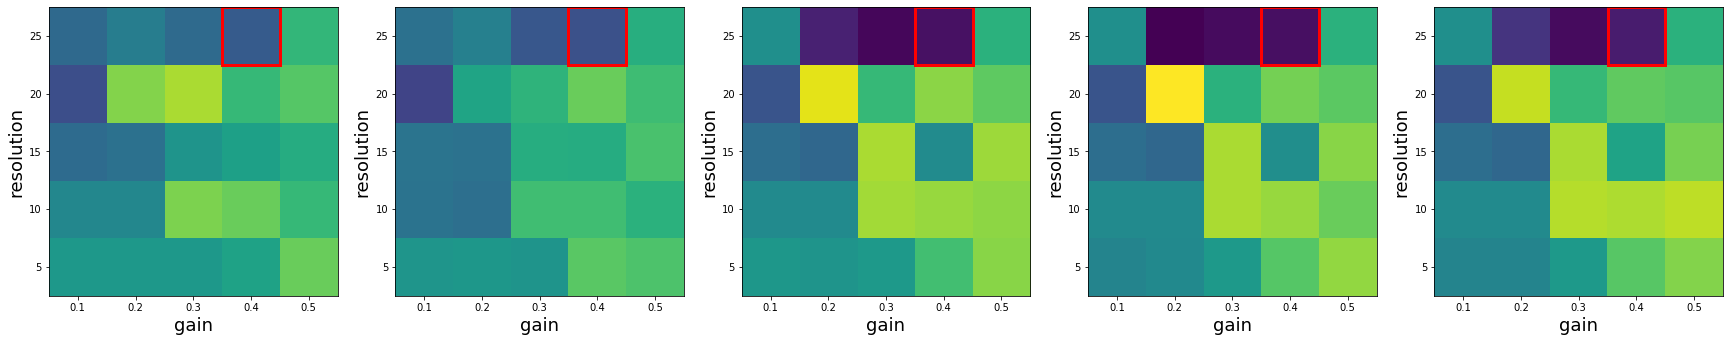

In [113]:
axes = plt.subplots(1,5, figsize=(30,30))[1].reshape(-1)
vmin = np.min(all_bootstrap_dist)
vmax = np.max(all_bootstrap_dist)
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

for b,ax in zip(all_bootstrap_dist,axes):
    ax.imshow(b,vmin=vmin,vmax=vmax)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(gains)
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(resolutions)
    ax.set_ylim(-.5,4.5)
    ax.set_xlabel('gain', fontsize=18)
    ax.set_ylabel('resolution', fontsize=18)
    highlight_cell(3,4, ax=ax,color="red", linewidth=3)

Text(0.5, 1.0, '95% CI of bottleneck distances')

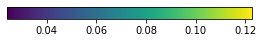

In [116]:
# axis of the colormap
a = np.array([[vmin,vmax]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a)
plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation='horizontal')
plt.title('95% CI of bottleneck distances')

## Visualizing the topological graphs for inspections.

In [117]:
resolution = 25
gain = 0.4
all_mappers = []
params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
          "resolutions": np.array([resolution]), "gains": np.array([gain]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=.15)}
for nf in [2,3,4,5,6]:
    exp = all_lime[nf]
    M = MapperComplex(**params).fit(exp)
    all_mappers.append(M)



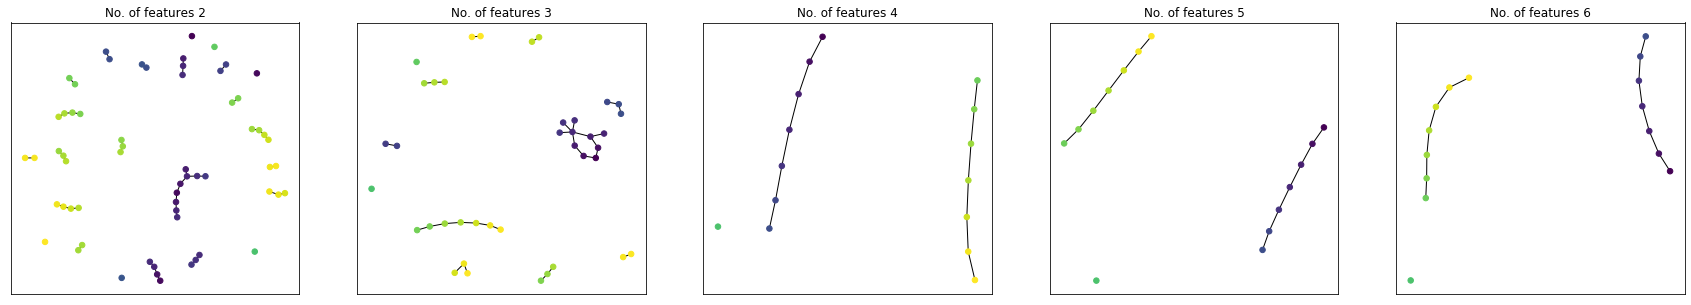

In [121]:
axes = plt.subplots(1, 5, figsize=(30,5))[1].reshape(-1)
i=2
for (M, ax) in zip(all_mappers, axes):
    G = mapper2networkx(M)
    nx.draw(G, pos=nx.spring_layout(G), 
            node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()], ax=ax,node_size=30)
    ax.axis('on')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title('No. of features {}'.format(i))
    i+=1
plt.show()

Text(0.5, 1.0, 'Prediction Probability')

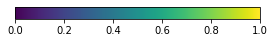

In [122]:
# axis of the colormap
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a)
plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation='horizontal')
plt.title('Prediction Probability')

## Compute the pairwise distances among the topological graphs with different LIME parameters.

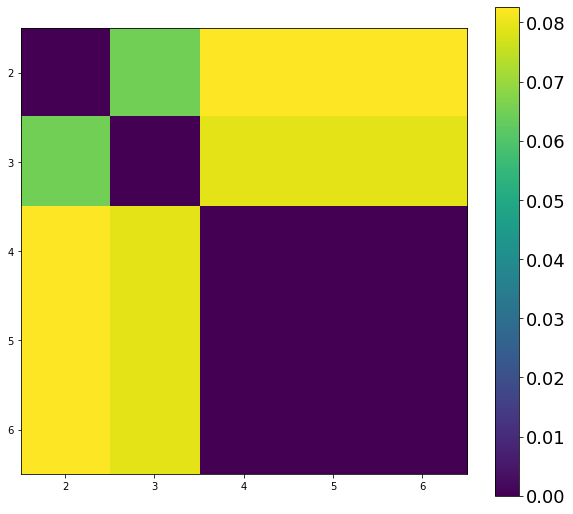

In [118]:
all_dists = np.zeros((5, 5))
for idx1 in range(len(all_mappers)):
    for idx2 in range(idx1+1, len(all_mappers)):
        all_dists[idx1, idx2] = bottleneck_distance(all_mappers[idx1], all_mappers[idx2])
        all_dists[idx2, idx1] = all_dists[idx1, idx2]
        
plt.figure(figsize=(10,9))
im = plt.imshow(all_dists)
plt.xticks([0,1,2,3,4],[2,3,4,5,6])
plt.yticks([0,1,2,3,4],[2,3,4,5,6])
plt.ylim(4.5,-0.5)
clb=plt.colorbar(im)
clb.ax.tick_params(labelsize=18) 
# clb.ax.set_title('bottleneck distance',fontsize=18)

## Plotting the row wise sum of pairwise distance matrices to highlight the differences

Text(0, 0.5, 'Rowwise sum from pairwise distance matrix')

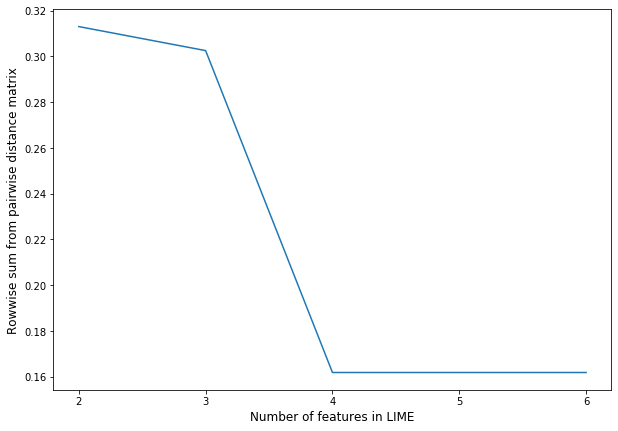

In [110]:
plt.figure(figsize=(10,7))
plt.plot(np.sum(all_dists, axis=0))
plt.xticks([0,1,2,3,4],[2,3,4,5,6])
plt.xlabel('Number of features in LIME',fontsize=12)
plt.ylabel("Rowwise sum from pairwise distance matrix",fontsize=12)